## Setup

In [66]:
import torch, torchvision
import argparse
import logging

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import math
from scipy.spatial import distance

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# import mediapipe for pose estimation
import mediapipe as mp
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates

## Configurations

In [67]:
data_path = "C:/Users/user/Desktop/RCP/ClimbAssistant/data"
test_path = os.path.join(data_path, 'test/cropped')
output_dir = os.path.join(data_path, 'output')

In [68]:
# set cofigurations for Detectron2
configs = {'classes': 1}

# settle the model configs
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.OUTPUT_DIR = output_dir
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = configs['classes']
predictor = DefaultPredictor(cfg)

# # get metadata from previous image runs
test_metadata = MetadataCatalog.get('val')

[01/12 18:13:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:/Users/user/Desktop/RCP/ClimbAssistant/data\output\model_final.pth ...


In [69]:
# Initialize mediapipe pose class.
mp_pose = mp.solutions.pose

# Setup the Pose function for images - independently for the images standalone processing.
pose_image = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Setup the Pose function for videos - for video processing.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.7,
                          min_tracking_confidence=0.7)

# Initialize mediapipe drawing class - to draw the landmarks points.
mp_drawing = mp.solutions.drawing_utils

## Run inference

In [70]:
file = os.path.join(test_path, "img_1.jpg")
im = cv2.imread(file)

In [71]:
# Use Mask RCNN model to run predictions
outputs = predictor(im)

# create a HSV frame to do colour categorization
hsv_frame = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

In [72]:
# Function that classify colour of each hold
# takes in input of Mask-RCNN predictions and the original RGB frame in HSV values
# returns a list of colours and contours for each hold
def classifyHolds(outputs, hsv_frame):   
    colour_list = []
    contours = []

    for pred_mask in outputs['instances'].pred_masks:
        mask = pred_mask.cpu().numpy().astype('uint8') # extract mask from predictions

        # Extract the contour of each predicted mask and save it in a list
        contour, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        contours.append(contour[0])

        mean = cv2.mean(im, mask=mask)
        hsv_mean = cv2.mean(hsv_frame, mask=mask) # calculate mean HSV values of each mask
        
        res = cv2.bitwise_and(im,im,mask = mask) # get only the masked portion of the image

        # get hue and value
        # hue is between 0 and 180, value is between 0 and 255
        hue = hsv_mean[0]
        saturation = hsv_mean[1]
        value = hsv_mean[2]

        # make use of hue to categorize colours
        color = "Undefined"
        if hue < 60:
            color = "YELLOW"
        elif hue < 90:
            color = "GREEN"
        elif hue < 120:
            color = "BLUE"
        else:
            color = "RED"
        
        # however, value is used to determine black and white, and hue is not useful
        # hence we reset the color if any of the holds are too dark or light as they should be classified as black and white respectively
        if value < 100:
            color = "BLACK"
        elif saturation < 140 and value > 160:
            color = "WHITE"

        colour_list.append(color)

    return colour_list, contours

In [73]:
# Function to detect pose of person in image and extract keypoints
# In our use case, we are interested in the left and right wrists coordinates
def detectPose(image, pose):
    
    image_in_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # openCV uses BGR, hence we need to convert to normal RGB
    
    resultant = pose.process(image_in_RGB) # perform pose detection

    keypoints = []

    # extract landmark coordinates from the defined variable and put them into a list
    # list has length of 33, for each body key-point detected
    if resultant.pose_landmarks:
        for data_point in resultant.pose_landmarks.landmark:
            keypoints.append({
                                'X': data_point.x,
                                'Y': data_point.y,
                                'Z': data_point.z
                                })
    
    # normalize the pixel values from mediapipe to draw using opencv
    image_rows, image_cols, _ = image.shape
    left_wrist = _normalized_to_pixel_coordinates(keypoints[15]['X'],keypoints[15]['Y'],image_cols,image_rows)
    right_wrist = _normalized_to_pixel_coordinates(keypoints[16]['X'],keypoints[16]['Y'],image_cols,image_rows)
    left_elbow = _normalized_to_pixel_coordinates(keypoints[13]['X'],keypoints[13]['Y'],image_cols,image_rows)
    right_elbow = _normalized_to_pixel_coordinates(keypoints[14]['X'],keypoints[14]['Y'],image_cols,image_rows)

    results = [left_wrist, right_wrist, left_elbow, right_elbow]

    return results

In [74]:
# Function to get the nearest hold to each of the left and right wrists
def nearestHold(contours, pose_results):
    holds = []
    for contour in contours:
        # find center of each contour
        M = cv2.moments(contour)

        if M["m00"] != 0: # to prevent division by 0
            center_X = int(M["m10"] / M["m00"])
            center_Y = int(M["m01"] / M["m00"])
        else:
            center_X, center_Y = 0, 0

        contour_center = (center_X, center_Y)

        # calculate distance to left and right wrists
        distances_to_left = (distance.euclidean(pose_results[0], contour_center))
        distances_to_right = (distance.euclidean(pose_results[1], contour_center))

        # save to a list of dictionaries
        holds.append({'contour': contour, 'center': contour_center, 'distance_to_left': distances_to_left, 'distance_to_right': distances_to_right})

    # Keep holds for left wrist if Y-coordinate for hold is less than Y-coordinate for left wrist
    # I am using less than because in OpenCV, (0,0) starts on the top left side
    # Means the hold must be higher than the wrist
    # Do the same for right wrist
    left_holds = [hold for hold in holds if hold['center'][1] <= pose_results[0][1]]
    right_holds = [hold for hold in holds if hold['center'][1] <= pose_results[1][1]]

    # next, we also want to find the nearest hold only if it is not the one the user is touching
    # Hence, the pointPolygonTest between the contour and left wrist must return -1 to represent that the left wrist is outside the contour
    # Do the same for right wrist
    left_holds = [hold for hold in left_holds if cv2.pointPolygonTest(hold['contour'], pose_results[0], False) == -1]
    right_holds = [hold for hold in right_holds if cv2.pointPolygonTest(hold['contour'], pose_results[1], False) == -1]

    # sort the holds and get the nearest to the left and right, and extract their center coordinates
    nearest_left = sorted(left_holds, key=lambda i: i['distance_to_left'])[0]['center']
    nearest_right = sorted(right_holds, key=lambda i: i['distance_to_right'])[0]['center']

    return nearest_left, nearest_right

In [75]:
colour_list, contours = classifyHolds(outputs, hsv_frame)

pose_results = detectPose(im, pose_image)

nearest_left, nearest_right = nearestHold(contours, pose_results)

In [76]:
# Function to calculate angle between 2 points
def calculateAngle(p1, p2):
    # Difference in x coordinates
    dx = p1[0] - p2[0]
    # Difference in y coordinates
    dy = p1[1] - p2[1]

    # calculate angle between 2 points and convert to degrees
    result = math.degrees(math.atan2(dy, dx))

    return result

In [88]:
def calculateAngleAndDistance(pose_results, left, right, frame):
    left_wrist, right_wrist, left_elbow, right_elbow = pose_results[0], pose_results[1], pose_results[2], pose_results[3]

    # calculate current arm angle (elbow to wrist)
    left_arm_angle = calculateAngle(left_elbow, left_wrist)
    right_arm_angle = calculateAngle(right_elbow, right_wrist)

    # calculate correct arm angle (elbow to hold)
    left_correct_angle = calculateAngle(left_elbow, left)
    right_correct_angle = calculateAngle(right_elbow, right)

    # calculate relative angle between current and correct arm angle
    left_relative_angle = left_arm_angle - left_correct_angle
    right_relative_angle = right_arm_angle - right_correct_angle
    print(f'left relative angle: {left_relative_angle}')
    print(f'right relative angle: {right_relative_angle}')

    height, width = frame.shape[:2]

    # calculate distance between wrist and next hold and arm length (elbow to wrist)
    # we take wrist - hold because origin is on top 
    left_dist = math.hypot(left_wrist[0] - left[0], left_wrist[1] - left[1])
    left_arm_length = abs(math.hypot(left_elbow[0] - left_wrist[0], left_elbow[1] - left_wrist[1]))
    
    right_dist = math.hypot(right_wrist[0] - right[0], right_wrist[1] - right[1])
    right_arm_length = abs(math.hypot(right_elbow[0] - right_wrist[0], right_elbow[1] - right_wrist[1]))

    # calculate relative distance from wrist to hold vs arm length
    left_relative_dist = left_dist / left_arm_length
    right_relative_dist = right_dist / right_arm_length
    print(f'left relative distance: {left_relative_dist}')
    print(f'right relative distance: {right_relative_dist}')



In [83]:
calculateAngleAndDistance(pose_results, nearest_left, nearest_right, im)

left relative angle: 4.864514437760519
right relative angle: 32.96940390346212
left height percentage: 0.42546882418053034
right height percentage: 2.0788314175120033


In [84]:
# dictionary to store BGR values for each colour
colour_values = {"YELLOW": (0,255,255), "GREEN": (0,255,0), "BLUE": (255,0,0), "RED": (0,0,255), "BLACK": (0,0,0), "WHITE": (255,255,255)}

In [85]:
def DrawOutputs(image, contours, colour_list, colour_values, pose_results):
    output_img = image.copy()

    # draw the contours we have obtained from our model with the correct colours
    for idx, contour in enumerate(contours):
        colour = colour_list[idx]
        cv2.drawContours(output_img, [contour], -1, colour_values[colour], 3)

    # draw circles on left and right wrists
    cv2.circle(output_img, pose_results[0], 3, (0,255,0), 3)
    cv2.circle(output_img, pose_results[1], 3, (0,0,255), 3)
    cv2.circle(output_img, pose_results[2], 3, (0,255,0), 3)
    cv2.circle(output_img, pose_results[3], 3, (0,0,255), 3)

    # draw circles on the 2 nearest holds
    cv2.circle(output_img, nearest_left, 3, (0,0,0), 3)
    cv2.circle(output_img, nearest_right, 3, (0,0,0), 3)

    plt.imshow(output_img[:, :, ::-1])
    plt.show()

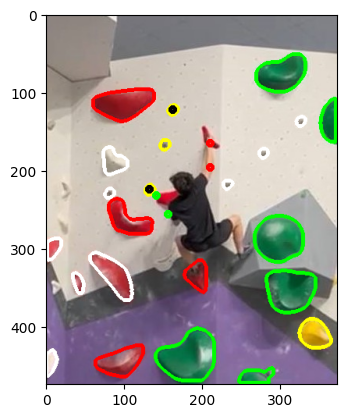

In [86]:
DrawOutputs(im, contours, colour_list, colour_values, pose_results)

## Run for all images

left relative angle: 4.864514437760519
right relative angle: 32.96940390346212
left relative distance: 0.42546882418053034
right relative distance: 2.0788314175120033


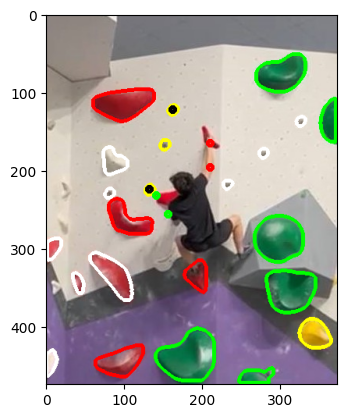

left relative angle: -30.579503463266292
right relative angle: -1.575921763763212
left relative distance: 1.4503367176555235
right relative distance: 1.01354643398651


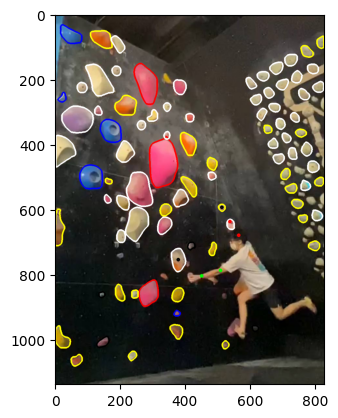

left relative angle: -2.6942842898560855
right relative angle: -5.9572024451431105
left relative distance: 2.274439914149618
right relative distance: 1.7955701647805218


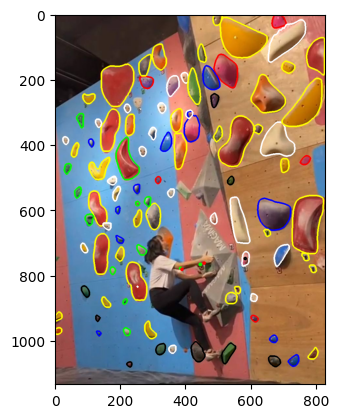

left relative angle: -134.4417216657014
right relative angle: 34.16800897605793
left relative distance: 7.400034798665424
right relative distance: 3.2492273494410937


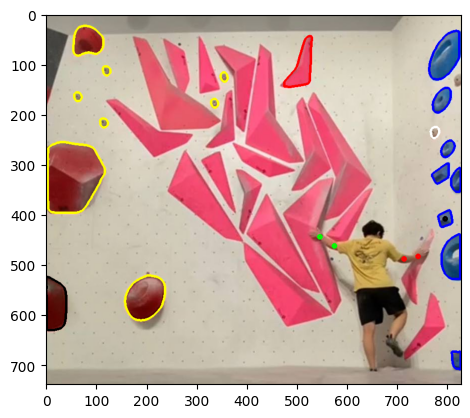

left relative angle: -89.82220141008585
right relative angle: -66.80140948635182
left relative distance: 1.4463736542089434
right relative distance: 3.5355339059327373


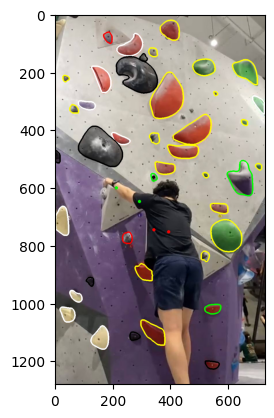

left relative angle: 78.55211647750919
right relative angle: -36.53485656853008
left relative distance: 1.826066694552457
right relative distance: 3.591902658185819


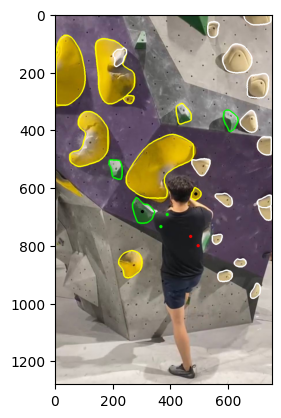

left relative angle: 44.07252708344103
right relative angle: 14.234663009348083
left relative distance: 4.563899325944494
right relative distance: 1.7566745689208754


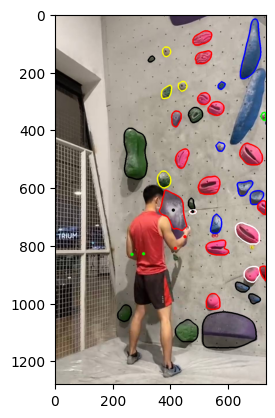

IndexError: list index out of range

In [89]:
for file in os.listdir(test_path):
    file_path = os.path.join(test_path, file)
    im = cv2.imread(file_path)

    # Use Mask RCNN model to run predictions
    outputs = predictor(im)

    # create a HSV frame to do colour categorization
    hsv_frame = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

    # get hold colours and contours
    colour_list, contours = classifyHolds(outputs, hsv_frame)

    # get human pose coordinates for left and right wrists
    pose_results = detectPose(im, pose_image)

    # get the nearest holds to the left and right wrists
    nearest_left, nearest_right = nearestHold(contours, pose_results)

    # calculate relative angle and distance to next hold
    calculateAngleAndDistance(pose_results, nearest_left, nearest_right, im)

    # draw results on image
    DrawOutputs(im, contours, colour_list, colour_values, pose_results)